<a href="https://colab.research.google.com/github/Sunny20235195/stock-market-price-prediction/blob/main/stock_prediction_using_LSTM_with_GA_ver2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1**: Khai báo các thư viện cần thiết

In [1]:
import numpy as np # thư viện tính toán số học
import pandas as pd # thư viện giúp đọc file và xử lí dữ liệu dạng bảng
import yfinance as yf # thư viện lấy dữ liệu
import tensorflow as tf # thư viện model
from tensorflow.keras.models import Sequential # Sắp xếp các lớp
from tensorflow.keras.layers import Layer, LSTM, Dense, Dropout # Các lớp sử dụng trong mô hình
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu
from sklearn.metrics import mean_squared_error # Tính độ lỗi
import matplotlib.pyplot as plt # Thư viện vẽ đồ thị
import random # random

**Step 2**: Tiền xử lí dữ liệu

In [ ]:
# Tải dữ liệu 10 năm dùng thư viện yfinance
def download_stock_data(ticker):
    data = yf.download(ticker, period="10y", interval="1d")
    return data


In [3]:
# Ví dụ về 1 mã cổ phiếu
data = download_stock_data("GOOG")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# Đảm bảo dữ liệu là của các ngày liên tục ('D': daily),
# các ngày không có dữ liệu (T7,CN) thì giá trị dữ liệu được gán NaN
data = data.asfreq('D')

# Kiểm tra 10 dòng đầu để đảm bảo không sót ngày nào
data.tail(10)

Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2025-05-19,167.869995,167.949997,165.414993,165.714996,21374700.0
2025-05-20,165.320007,169.679993,164.259995,167.759995,33563300.0
2025-05-21,170.059998,174.529999,164.889999,164.949997,45567600.0
2025-05-22,171.979996,178.130005,171.880005,173.350006,45024100.0
2025-05-23,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-24,NaN,NaN,NaN,NaN,NaN
2025-05-25,NaN,NaN,NaN,NaN,NaN
2025-05-26,NaN,NaN,NaN,NaN,NaN


In [5]:
# fillna() là hàm dùng để ghi đè các ô có giá trị NaN
# method='ffill' (forward fill) nghĩa là: Nếu một ô có giá trị NaN,
# hãy lấy giá trị ở dòng phía trên nó để điền vào ()
data = data.fillna(method='ffill')

# Kiểm tra 10 dòng đầu để đảm bảo không còn giá trị NaN nào.
data.tail(10)

C:\Users\admin\AppData\Local\Temp\ipykernel_55256\410669001.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2025-05-19,167.869995,167.949997,165.414993,165.714996,21374700.0
2025-05-20,165.320007,169.679993,164.259995,167.759995,33563300.0
2025-05-21,170.059998,174.529999,164.889999,164.949997,45567600.0
2025-05-22,171.979996,178.130005,171.880005,173.350006,45024100.0
2025-05-23,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-24,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-25,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-26,169.589996,171.205002,169.259995,170.279999,24963600.0


In [6]:
# Lấy ra duy nhất cột giá đóng cửa (Close) –
# đây là dữ liệu quan trọng nhất trong phân tích tài chính và dự báo.
close_prices = data[['Close']]

# Kiểm tra 10 giá trị đầu của chuỗi Close, để đảm bảo dữ liệu được lọc đúng.
close_prices.tail(10)

Price,Close
Ticker,GOOG
Date,
2025-05-19,167.869995
2025-05-20,165.320007
2025-05-21,170.059998
2025-05-22,171.979996
2025-05-23,169.589996
2025-05-24,169.589996
2025-05-25,169.589996
2025-05-26,169.589996


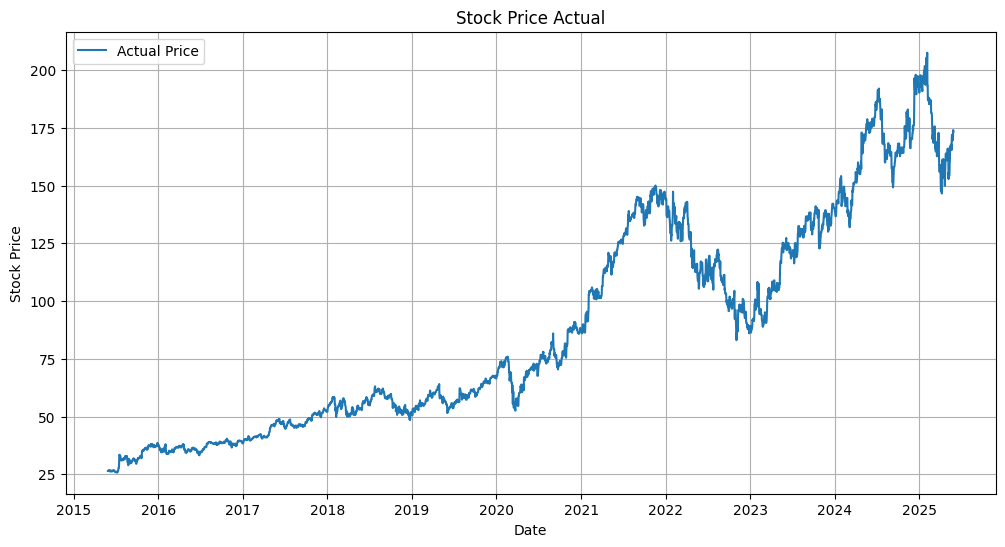

In [7]:
# Vẽ đồ thị giá thực
dates = data.index[:]
plt.figure(figsize=(12, 6))
plt.plot(dates, close_prices, label='Actual Price')
plt.title('Stock Price Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


**Step 3**: Implement LSTM

In [9]:
# Lớp LSTM tùy chỉnh kế thừa từ tf.keras.layers.Layer
class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units  # số lượng đơn vị ẩn (neurons)
        self.return_sequences = return_sequences  # có trả về toàn bộ chuỗi hay chỉ bước cuối

    def build(self, input_shape):
        self.input_dim = input_shape[-1]  # số chiều của đầu vào tại mỗi bước thời gian

        # Ma trận trọng số cho đầu vào x_t
        self.W_f = self.add_weight(shape=(self.input_dim, self.units), initializer="glorot_uniform", name="W_f")  # forget gate
        self.W_i = self.add_weight(shape=(self.input_dim, self.units), initializer="glorot_uniform", name="W_i")  # input gate
        self.W_c = self.add_weight(shape=(self.input_dim, self.units), initializer="glorot_uniform", name="W_c")  # candidate cell
        self.W_o = self.add_weight(shape=(self.input_dim, self.units), initializer="glorot_uniform", name="W_o")  # output gate

        # Ma trận trọng số cho trạng thái ẩn h_t
        self.U_f = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_f")
        self.U_i = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_i")
        self.U_c = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_c")
        self.U_o = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_o")

        # Các bias cho từng cổng
        self.b_f = self.add_weight(shape=(self.units,), initializer="zeros", name="b_f")
        self.b_i = self.add_weight(shape=(self.units,), initializer="zeros", name="b_i")
        self.b_c = self.add_weight(shape=(self.units,), initializer="zeros", name="b_c")
        self.b_o = self.add_weight(shape=(self.units,), initializer="zeros", name="b_o")

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]      # số lượng mẫu trong batch
        time_steps = inputs.shape[1]          # số bước thời gian (sequence length)
        h_t = tf.zeros((batch_size, self.units))  # khởi tạo trạng thái ẩn ban đầu h_0
        c_t = tf.zeros((batch_size, self.units))  # khởi tạo trạng thái ô nhớ ban đầu c_0
        outputs = []  # lưu tất cả hidden states theo thời gian

        # Duyệt qua từng bước thời gian
        for t in range(time_steps):
            x_t = inputs[:, t, :]  # lấy đầu vào tại thời điểm t

            # Tính toán các cổng
            f_t = tf.sigmoid(tf.matmul(x_t, self.W_f) + tf.matmul(h_t, self.U_f) + self.b_f)  # cổng quên
            i_t = tf.sigmoid(tf.matmul(x_t, self.W_i) + tf.matmul(h_t, self.U_i) + self.b_i)  # cổng đầu vào
            o_t = tf.sigmoid(tf.matmul(x_t, self.W_o) + tf.matmul(h_t, self.U_o) + self.b_o)  # cổng đầu ra
            c_hat_t = tf.tanh(tf.matmul(x_t, self.W_c) + tf.matmul(h_t, self.U_c) + self.b_c)  # giá trị ô nhớ ứng viên

            # Cập nhật trạng thái ô nhớ và trạng thái ẩn
            c_t = f_t * c_t + i_t * c_hat_t  # công thức cập nhật trạng thái ô nhớ
            h_t = o_t * tf.tanh(c_t)         # công thức cập nhật trạng thái ẩn

            outputs.append(h_t)  # lưu trạng thái ẩn hiện tại

        # Kết quả có shape (batch_size, time_steps, units)
        outputs = tf.stack(outputs, axis=1)

        if self.return_sequences:
            return outputs            # trả về toàn bộ chuỗi các trạng thái ẩn
        else:
            return outputs[:, -1, :]  # chỉ trả về trạng thái ẩn cuối cùng (cuối chuỗi)


In [22]:
# Step 3: Build LSTM model
def build_model(input_shape, units=50):
    model = Sequential() # giúp xếp các lớp
    model.add(CustomLSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(CustomLSTM(units, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

**Step 3.2**: Option sử dụng LSTM của thư viện (nhanh hơn) (không chạy đoạn code này khi đã chạy phần Step 3 và ngược lại)


In [8]:
# Step 3.2: Build LSTM model using library
def build_model(input_shape, units=50):
    model = Sequential() # giúp xếp các lớp
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

**Step 4**: Tối ưu hóa bằng GA

In [9]:
# Prepare data
def create_dataset(data, window_size=60): # kích thước của sổ mặc định(nếu không truyền vào thì window_size=60)
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

**Ý tưởng**: tối ưu bộ tham số (window_size, units) sử dụng GA với số thế hệ là 5, số cá thể của mỗi thế hệ là 30, tỉ lệ lai ghép: 0.8, tỉ lệ đột biến: 0.05. Không gian tìm kiếm: 180 * 4 = 720 (180 giá trị window_size, 4 giá trị units)
Chiến lược chọn thế hệ sau: Giữ lại 1/ 6 thế hệ trước có fitness tốt nhất(5 cá thể), Chọn 2/3 cá thể tốt nhất ở thế hệ trước(20 cá thể) để chọn ngẫu nhiên trong đó 2 cá thể để lai ghép(nếu có), sau đó cho cá thể con đột biến(nếu có). Lặp lại quá trình cho đến khi đủ số lượng cá thể(30 cá thể) cho thế hệ tiếp theo.

In [13]:
# Lấy dữ liệu gốc
close_prices = data['Close'].values.reshape(-1, 1)
total_len = len(close_prices)

# Chia theo 80% train, 10% val, 10% test
train_end = int(0.8 * total_len)
val_end = int(0.9 * total_len)

# ⚠️ Giữ lại 90 ngày trước khi chia để đủ cho mọi window_size
max_window_size = 90
train_raw = close_prices[:train_end]
val_raw = close_prices[train_end - max_window_size:val_end]
test_raw = close_prices[val_end - max_window_size:]

# Chuẩn hóa
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_raw)
val_scaled = scaler.transform(val_raw)
test_scaled = scaler.transform(test_raw)


In [ ]:
# Step 4: Genetic Algorithm for hyperparameter tuning
def genetic_algorithm(population_size=10, max_generations=30, mutation_rate=0.1, crossover_rate=0.8, patience=5, target_mse=0.001, no_improve_count=0, select_top_k = 2, select_top_n_crossover=6): # Các thông số trong GA
    # --------------------------
    # 1. Create a random individual
    def create_individual():
        return {
            'window_size': random.randint(30, 90), # Kích thước cửa sổ chọn từ 30 đến 90 ngày (có thể thay đổi)
            'units': random.choice([32, 64, 128]) # Số units trên 1 lớp LSTM. Chọn các số này là vì GPU, TPU tính toán hiệu quả hơn với các giá trị unit là bội của 32
        }

    # --------------------------
    # 2. Evaluate fitness (lower MSE is better)
    def fitness(ind):
        window_size = ind['window_size']
        units = ind['units']
        # Tạo dataset từ tập đã chia & chuẩn hóa
        X_train, y_train = create_dataset(train_scaled, window_size)
        X_val, y_val = create_dataset(val_scaled, window_size)

        model = build_model((window_size, 1), units=units)
        model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=0)
        preds = model.predict(X_val)

        mse = mean_squared_error(y_val, preds)
        return mse
# tính MSE (fitness định nghĩa ở đây thì cá thể có fitness càng nhỏ thì cá thể đó càng tốt)  tổng sigma (y_val_gen -preds)^2 MSE

    # --------------------------
    # 3. Selection: sort by fitness (elitism: top N)
    def selection(population, scores, num_elites=select_top_k):
        sorted_pop = [x for _, x in sorted(zip(scores, population))]
        return sorted_pop[:num_elites] # lấy trước 15 cá thể tốt nhất (fitness thấp nhất)

    # --------------------------
    # 4. Crossover: combine 2 parents into 1 child
    def crossover(parent1, parent2):
        if random.random() < crossover_rate: # nếu random ra < tỉ lệ lai ghép thì cho lai.
            return {
                'window_size': random.choice([parent1['window_size'], parent2['window_size']]),
                'units': random.choice([parent1['units'], parent2['units']])
            }
        else:
            # No crossover, just clone one of the parents(nếu ko thì ko làm gì)
            return random.choice([parent1, parent2]).copy()


    # --------------------------
    # 5. Mutation: randomly alter genes
    def mutate(ind):
        if random.random() < mutation_rate: # random ra nhỏ hơn tỉ lệ đột biến thì cho đột biến
            ind['window_size'] = random.randint(30, 90)
        if random.random() < mutation_rate:
            ind['units'] = random.choice([32, 64, 128])
        return ind

    # --------------------------
    # 6. Replacement: create new generation from elites + offspring
    def create_next_generation(elites, population, size, scores):
        next_gen = elites[:]
        sorted_pop = [x for _, x in sorted(zip(scores, population))]
        while len(next_gen) < size:
            parent1, parent2 = random.sample(sorted_pop[:select_top_n_crossover], 2) # chọn 4 cá thể tốt nhất xong chọn 2 bố mẹ. Rồi tiến hành lai ghép, đột biến nếu có.
            child = crossover(parent1, parent2) # lai ghép
            child = mutate(child) # đột biến
            next_gen.append(child) # thêm vào thế hệ sau
        return next_gen

    # --------------------------
    # 7. Repeat over generations
    population = [create_individual() for _ in range(population_size)]
    best_individual = None
    best_score = float('inf')

    for gen in range(max_generations):
        print(f"\n Generation {gen+1}")
        scores = [fitness(ind) for ind in population]
        for i, (ind, score) in enumerate(zip(population, scores)):
            print(f"Individual {i+1}: window_size={ind['window_size']}, units={ind['units']}, MSE={score:.6f}")

        elites = selection(population, scores, num_elites=select_top_k)
        best_elite = elites[0]
        best_elite_score = scores[population.index(best_elite)]  # lấy đúng fitness đã tính
        print(f"Best individual of generation {gen+1}: window_size={best_elite['window_size']}, units={best_elite['units']}, MSE={best_elite_score:.6f}")

        if best_elite_score < best_score: # lấy cá thể tốt nhất trong tất cả những lần lai ghép
            best_score = best_elite_score
            best_individual = best_elite.copy()
        # 🔸 Điều kiện dừng sớm
     
        # Kiểm tra cải thiện
        if best_elite_score < best_score:
            best_score = best_elite_score
            best_individual = best_elite.copy()
            no_improve_count = 0  # reset bộ đếm
        else:
            no_improve_count += 1
            print(f"No improvement for {no_improve_count} generation(s)")

        # 🔴 DỪNG SỚM nếu không cải thiện trong `patience` thế hệ
        if no_improve_count >= patience:
            print(f"\nEarly stopping: No improvement in the last {patience} generations.")
            break
        # 🔴 Dừng sớm nếu đạt MSE mục tiêu
        if best_elite_score <= target_mse:
            print(f"\n✅ Early stopping: Reached target MSE ≤ {target_mse}")
            break


        population = create_next_generation(elites, population, population_size, scores) # tạo thế hệ mới (gồm 5 cá thể tốt nhất của thế hệ trước và những cá thể khác được lai ghép, đột biến)


    print(f"\n Final best individual: window_size={best_individual['window_size']}, units={best_individual['units']}, MSE={best_score:.6f}")
    return best_individual

Step 5: Chạy thuật toán GA để tìm ra cá thể tốt nhất

In [39]:
# GA optimization
best_params = genetic_algorithm(population_size=10, select_top_k=2, select_top_n_crossover=6)
print("Best Parameters from GA:", best_params)


 Generation 1
12/12 [==============================] - 1s 9ms/step
Individual 1: window_size=72, units=64, MSE=0.001420
Individual 2: window_size=77, units=128, MSE=0.001208
Individual 3: window_size=62, units=32, MSE=0.001365
Individual 4: window_size=51, units=128, MSE=0.002681
Individual 5: window_size=31, units=128, MSE=0.001129
Individual 6: window_size=65, units=32, MSE=0.003410
Individual 7: window_size=85, units=64, MSE=0.003538
Individual 8: window_size=36, units=32, MSE=0.003208
Individual 9: window_size=84, units=64, MSE=0.005458
Individual 10: window_size=78, units=32, MSE=0.003299
Best individual of generation 1: window_size=31, units=128, MSE=0.001129
No improvement for 1 generation(s)

 Generation 2
14/14 [==============================] - 1s 10ms/step
Individual 1: window_size=31, units=128, MSE=0.001449
Individual 2: window_size=77, units=128, MSE=0.011616
Individual 3: window_size=77, units=64, MSE=0.003929
Individual 4: window_size=36, units=32, MSE=0.011826
Individ

**Step 6**: Huấn luyện và tính RMSE đối với cá thể tốt nhất được chọn

In [40]:
from keras.callbacks import EarlyStopping

# 1. Lấy dữ liệu gốc (chưa chuẩn hóa)
close_prices = data['Close'].values.reshape(-1, 1)

# 2. Chia dữ liệu theo tỉ lệ 80% train, 10% val, 10% test
total_len = len(close_prices)
train_end = int(total_len * 0.8)
val_end = int(total_len * 0.9)

train_prices = close_prices[:train_end]
val_prices = close_prices[train_end - best_params['window_size']:val_end]
test_prices = close_prices[val_end - best_params['window_size']:]  # giữ lại window_size ngày

# 3. Fit scaler trên tập train và transform cả 3 phần
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_val = scaler.transform(val_prices)
scaled_test = scaler.transform(test_prices)

# 4. Tạo dataset
X_train, y_train = create_dataset(scaled_train, best_params['window_size'])
X_val, y_val = create_dataset(scaled_val, best_params['window_size'])
X_test, y_test = create_dataset(scaled_test, best_params['window_size'])

# 5. Gộp train + val để train mô hình cuối cùng
X_final_train = np.concatenate([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

# 6. Xây mô hình
model = build_model((best_params['window_size'], 1), best_params['units'])

# 7. EarlyStopping (monitor trên `loss` vì không có val)
early_stop = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

# 8. Huấn luyện trên train + val
model.fit(
    X_final_train, y_final_train,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# 9. Dự đoán trên test set và tính RMSE
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("✅ Test RMSE:", rmse)

Epoch 1/100
102/102 [==============================] - 8s 25ms/step - loss: 0.0086
Epoch 2/100
102/102 [==============================] - 2s 19ms/step - loss: 0.0021
Epoch 3/100
102/102 [==============================] - 2s 22ms/step - loss: 0.0020
Epoch 4/100
102/102 [==============================] - 2s 20ms/step - loss: 0.0017
Epoch 5/100
102/102 [==============================] - 2s 20ms/step - loss: 0.0019
Epoch 6/100
102/102 [==============================] - 2s 21ms/step - loss: 0.0018
Epoch 7/100
102/102 [==============================] - 2s 18ms/step - loss: 0.0015
Epoch 8/100
102/102 [==============================] - 2s 21ms/step - loss: 0.0015
Epoch 9/100
102/102 [==============================] - 2s 19ms/step - loss: 0.0016
Epoch 10/100
102/102 [==============================] - 2s 19ms/step - loss: 0.0015
Epoch 11/100
102/102 [==============================] - 2s 17ms/step - loss: 0.0014
Epoch 12/100
102/102 [==============================] - 2s 18ms/step - loss: 0.0012
E

12/12 [==============================] - 0s 8ms/step


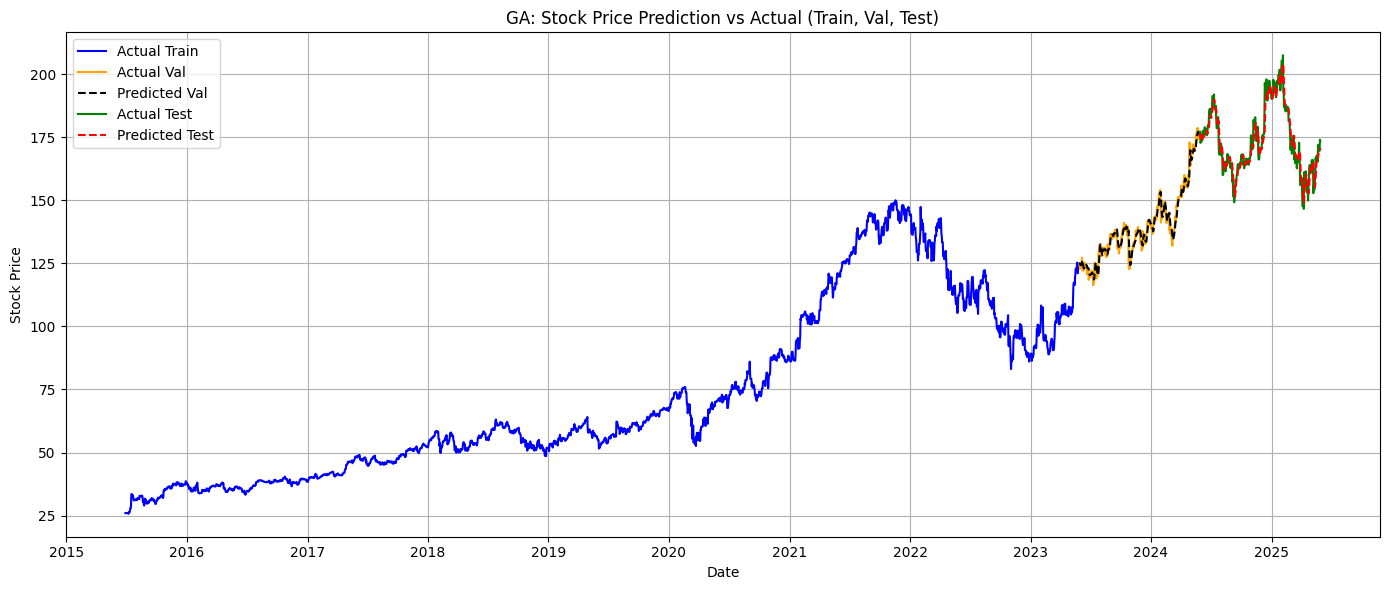

In [41]:
# Dự đoán từng phần
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

# Inverse transform các phần
y_train_rescaled = scaler.inverse_transform(y_train)
train_preds_rescaled = scaler.inverse_transform(train_preds)

y_val_rescaled = scaler.inverse_transform(y_val)
val_preds_rescaled = scaler.inverse_transform(val_preds)

y_test_rescaled = scaler.inverse_transform(y_test)
test_preds_rescaled = scaler.inverse_transform(test_preds)

# Lấy index ngày tương ứng
train_start = best_params['window_size']
val_start = train_end
test_start = val_end

train_dates = data.index[train_start:train_start + len(y_train)]
val_dates = data.index[val_start:val_start + len(y_val)]
test_dates = data.index[test_start:test_start + len(y_test)]

# Vẽ biểu đồ chung
plt.figure(figsize=(14, 6))
plt.plot(train_dates, y_train_rescaled, label='Actual Train', color='blue')
#plt.plot(train_dates, train_preds_rescaled, label='Predicted Train', color='black', linestyle='--')

plt.plot(val_dates, y_val_rescaled, label='Actual Val', color='orange')
plt.plot(val_dates, val_preds_rescaled, label='Predicted Val', color='black', linestyle='--')

plt.plot(test_dates, y_test_rescaled, label='Actual Test', color='green')
plt.plot(test_dates, test_preds_rescaled, label='Predicted Test', color='red', linestyle='--')

plt.title('GA: Stock Price Prediction vs Actual (Train, Val, Test)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


12/12 [==============================] - 0s 22ms/step
Độ sai số trung bình trên tập validation: 1.8714648103060787 dolar


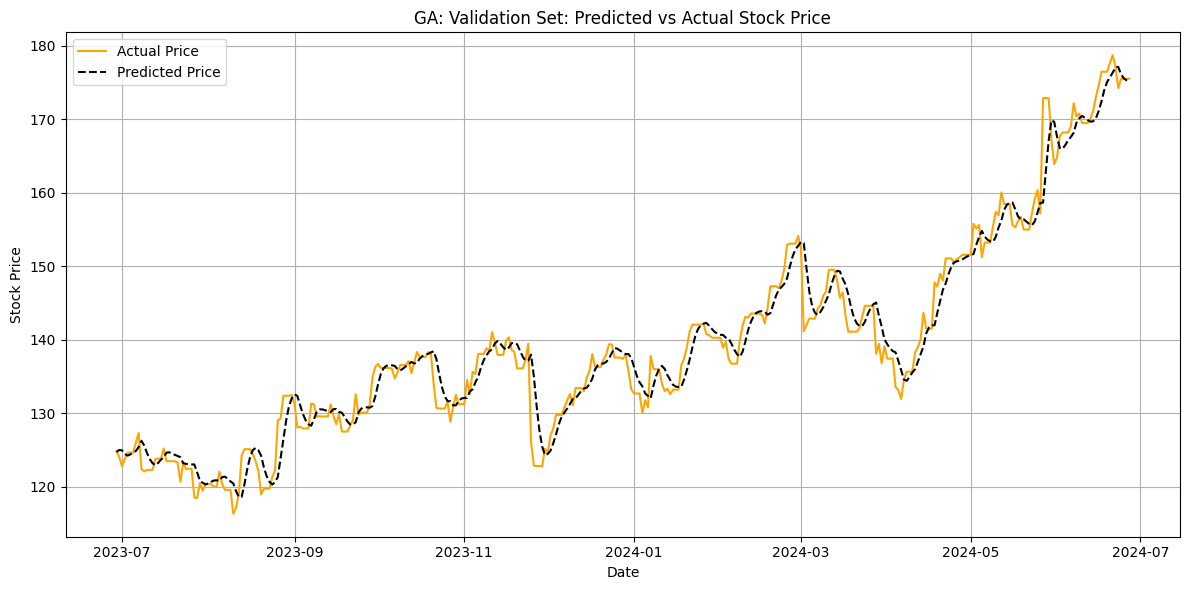

In [42]:
# Dự đoán trên tập validation
val_preds = model.predict(X_val)

# Inverse transform y_val và dự đoán
y_val_rescaled = scaler.inverse_transform(y_val)
val_preds_rescaled = scaler.inverse_transform(val_preds)

# MAE trên tập validation
val_mae = np.mean(np.abs(y_val_rescaled - val_preds_rescaled))
print("Độ sai số trung bình trên tập validation:", val_mae, "dolar")

# Lấy index ngày đúng cho tập validation
val_start_index = train_end + best_params['window_size']
val_dates = data.index[val_start_index : val_start_index + len(y_val)]

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(val_dates, y_val_rescaled, label='Actual Price', color='orange')
plt.plot(val_dates, val_preds_rescaled, label='Predicted Price', color='black', linestyle='--')
plt.title('GA: Validation Set: Predicted vs Actual Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Độ sai số trung bình trên tập test: 2.6269286525705473 dolar
MAPE trên tập test: 1.52%


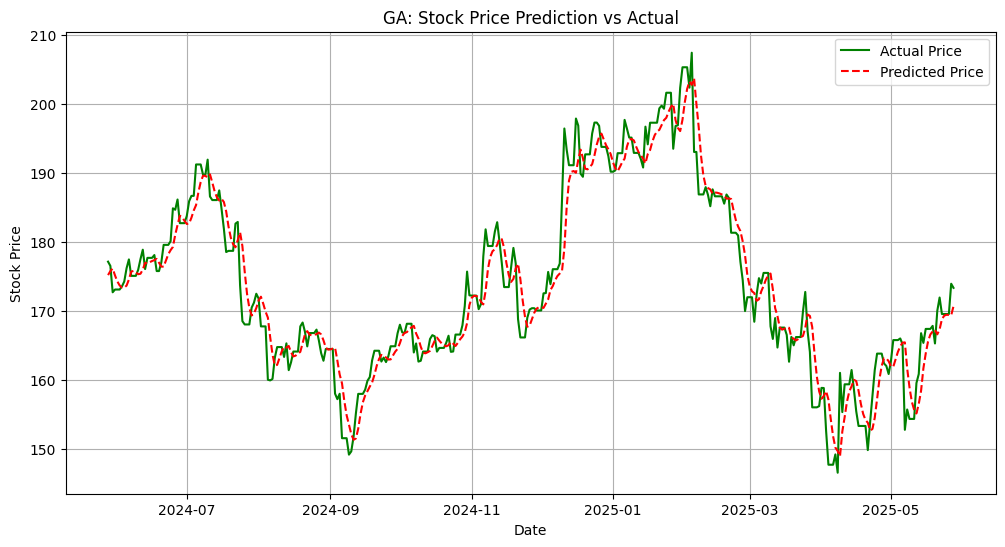

In [43]:
# Plot predictions vs actual
y_test_rescaled = scaler.inverse_transform(y_test)
preds_rescaled = scaler.inverse_transform(preds)
mae = np.mean(np.abs(y_test_rescaled- preds_rescaled))
print("Độ sai số trung bình trên tập test:", mae, "dolar")
mape = np.mean(np.abs((y_test_rescaled - preds_rescaled) / y_test_rescaled)) * 100 # Tỷ lệ phần trăm sai số trung bình
print(f"MAPE trên tập test: {mape:.2f}%")
# Get the corresponding dates for the last 100 entries (the test set)
dates = data.index[-len(y_test):]  # data is the original DataFrame from yfinance
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_rescaled, label='Actual Price', color='green')
plt.plot(dates, preds_rescaled, label='Predicted Price', color='red', linestyle='--')
plt.title('GA: Stock Price Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


**Step 8**: Vẽ đồ thị 100 ngày gần nhất

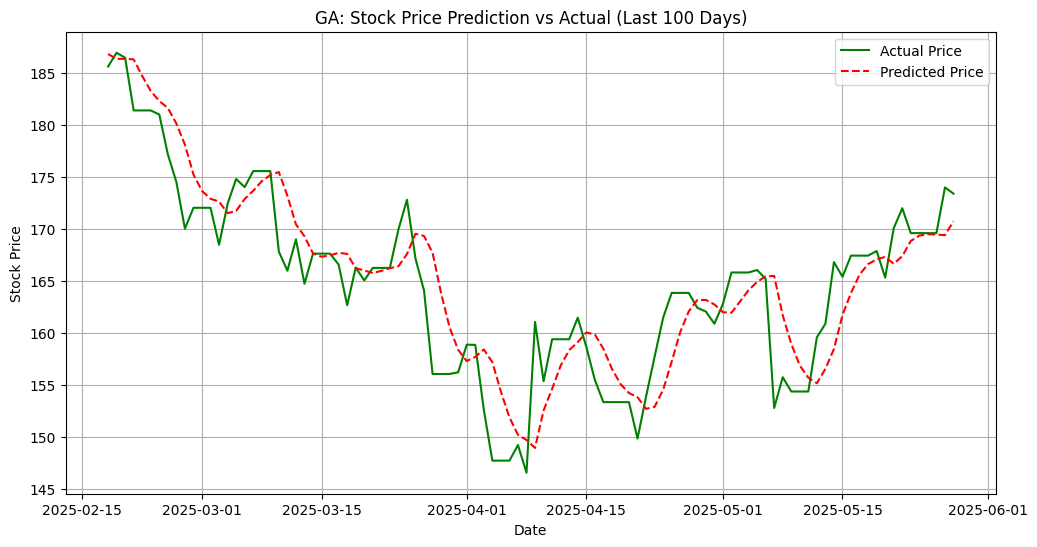

In [44]:
# Chỉ lấy 100 mẫu cuối cùng
num_plot = 100
y_test_subset = y_test[-num_plot:]
preds_subset = preds[-num_plot:]

# Biến đổi ngược lại giá gốc
y_test_rescaled = scaler.inverse_transform(y_test_subset)
preds_rescaled = scaler.inverse_transform(preds_subset)

# Lấy đúng 100 ngày cuối tương ứng trong dữ liệu gốc
dates = data.index[-num_plot:]

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_rescaled, label='Actual Price', color='green')
plt.plot(dates, preds_rescaled, label='Predicted Price', color='red', linestyle='--')
plt.title('GA: Stock Price Prediction vs Actual (Last 100 Days)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


**Step 9:** Dự đoán giá những ngày sau đó (Chưa có dữ liệu thực)



In [ ]:
def predict_next_days(model, last_sequence, days_to_predict=30, scaler=None):
    """
    Dự đoán `days_to_predict` ngày tiếp theo dựa vào chuỗi đầu vào `last_sequence`.
    Trả về danh sách các giá trị thực tế (đã inverse_transform nếu cần).
    """
    predicted = []
    current_input = last_sequence.reshape(1, last_sequence.shape[0], 1)

    for _ in range(days_to_predict):
        next_price = model.predict(current_input, verbose=0)[0][0]
        predicted.append(next_price)
        current_input = np.append(current_input[:, 1:, :], [[[next_price]]], axis=1)

    if scaler:
        predicted = scaler.inverse_transform(np.array(predicted).reshape(-1, 1)).flatten()

    return predicted


In [ ]:
# Lấy ngày cuối cùng trong dữ liệu yfinance
last_date = data.index[-1]

# Tạo 30 ngày làm việc tiếp theo (bỏ cuối tuần)
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=30)


In [ ]:
# Lấy chuỗi gần nhất
last_sequence = scaled_test[-best_params['window_size']:]

# Dự đoán 30 ngày tới
predicted_prices = predict_next_days(model, last_sequence, days_to_predict=30, scaler=scaler)

# In kết quả theo ngày
for date, price in zip(future_dates, predicted_prices):
    print(f"{date.strftime('%Y-%m-%d')}: {price:.2f}")


In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predicted_prices, label='Predicted Price (Next 30 Days)', color='orange')
plt.title('Predicted Stock Prices for Next 30 Business Days')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**Step 10**: Thêm vòng for để dự đoán nhiều loại cổ phiếu (Code y như phần dự đoán 1 cổ phiếu chỉ thêm vòng for)

In [ ]:
symbols = ["AAPL", "GOOG", "MSFT", "AMZN"]

In [ ]:
for symbol in symbols:
    print(f"\n========= Processing {symbol} =========")

    # code này y như phần trên
    #1. Tiền xử lí
    data = download_stock_data(symbol)
    data = data.asfreq('D')
    data = data.fillna(method='ffill')
    # Tìm giá trị tối ưu
    best_params = genetic_algorithm()
    print("Best Parameters from GA:", best_params)

    # 2. Chia dữ liệu trước khi scale
    split_index = int(len(close_prices) * 0.8)
    train_prices = close_prices[:split_index]
    test_prices = close_prices[split_index - best_params['window_size']:]

    # 3. Fit scaler trên tập train và transform cả hai phần
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train_prices)
    scaled_test = scaler.transform(test_prices)

    # 4. Tạo dataset
    X_train_final, y_train_final = create_dataset(scaled_train, best_params['window_size'])
    X_test, y_test = create_dataset(scaled_test, best_params['window_size'])

    model = build_model((best_params['window_size'], 1), best_params['units'])
    model.fit(X_train_final, y_train_final, epochs=30, batch_size=32, verbose=1)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("Test RMSE:", rmse)

    y_test_rescaled = scaler.inverse_transform(y_test)
    preds_rescaled = scaler.inverse_transform(preds)
    dates = data.index[-len(y_test):]

    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test_rescaled, label='Actual Price')
    plt.plot(dates, preds_rescaled, label='Predicted Price')
    plt.title(f'{symbol} Stock Price Prediction vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()
